<a href="https://colab.research.google.com/github/TejaPravs/Homework2/blob/main/Emotional_tone_prediction_in_movies_using_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Roberta for Emotional tone Prediction in Movies




**Introduction:**
In this project, I will be fine-tuning a RoBERTa model for Emotional Tone Prediction in Movies. Unlike traditional sentiment analysis, this project focuses on classifying nuanced emotional tones from movie descriptions, such as
humorous, inspiring, heartwarming, bittersweet, euphoric, melancholic, tense, romantic, nostalgic, intriguing, comforting, provocative, empowering, profound, enchanting, alarming, perilous, ominous, fearless, imaginative, methodical, investigative, intellectual, sophisticated, innovative, futuristic, wholesome, raw, and optimistic.

Since the dataset does not come with pre-labeled emotional tones, I generated these labels using the GPT-4o-mini API. This enriched dataset is then used to fine-tune a pre-trained RoBERTa model, enabling it to classify movie descriptions into one or more of these 29 emotional tones.

**Workflow of the Notebook:**
The notebook is organized into several sections, providing a clear walkthrough of the process used. This structure can be adapted for similar use cases. The sections are:

1.   Setting Up the Environment and Libraries
2.   Loading and Cleaning the Movie Dataset
3.   Building the Dataset for Model Training
4.   Defining the Model Architecture
5.   Training the Model with Fine-Tuning
6.   Evaluating Model Performance
7.   Saving the Trained Model for Future Use

**Technical Details:**
This project leverages various tools and resources to implement emotional tone prediction. Below are the key elements used. Ensure these are available in your environment to successfully run the notebook.

**Data:**

I am using the dataset available at Kaggle Movies Dataset.
Movie descriptions from this dataset are processed, and emotional tone labels are generated using the GPT-4o-mini API.
Language Model Used:

[The RoBERTa model, proposed](https://scholar.google.ca/citations?view_op=view_citation&hl=vi&user=H9buyroAAAAJ&citation_for_view=H9buyroAAAAJ:2osOgNQ5qMEC) in "RoBERTa: A Robustly Optimized BERT Pretraining Approach" by Yinhan Liu et al., is a robust language model optimized for NLP tasks.

**References:**

[Blog Post](https://ai.meta.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/)

[Research Paper](https://arxiv.org/pdf/1907.11692)

[Documentation for Python](https://huggingface.co/docs/transformers/model_doc/roberta)

**Hardware Requirements:**
- Python version 3.10 or above
- PyTorch, Transformers, and standard Python ML libraries
- A GPU-enabled setup for efficient fine-tuning and evaluation
This notebook demonstrates how to prepare and fine-tune a model for emotional tone prediction, offering a flexible framework for similar classification tasks in NLP.

In [1]:
!pip install transformers
import transformers
print(transformers.__version__)

4.47.1


<a id='section01'></a>
### Importing Python Libraries and preparing the environment

In this section, I will import the essential libraries and modules required for the project.

These include:
*   Pandas: For data manipulation and analysis.
*   NumPy: For numerical operations.

*   scikit-learn: For dataset splitting and other utilities.

*   PyTorch: For building and training the model.

*   Transformers: For loading and fine-tuning the pre-trained RoBERTa model.

*   tqdm: For progress tracking during loops and data loading.

*   torch.utils.data: For managing datasets and dataloaders.

*   logging: For handling and suppressing unwanted log messages.


Finally, I configure the environment to utilize GPU (CUDA) if available. This ensures faster training and fine-tuning of the model by leveraging GPU capabilities.

In [2]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers

import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [3]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In this section, I load, clean and preprocess the movie dataset to ensure it is ready for training the model. Here is a breakdown of the steps:

Firstly i have loaded the dataset using pandas and stored in 'movies_df'

**Handling Missing Values in Descriptions:**

The overview column contains a placeholder text "No overview found." for missing movie descriptions. These entries are replaced with NaN values for easier handling.
I then remove rows with missing values in the overview column to ensure that all movies have a valid description.

**Filtering Invalid Emotional Tone Labels:**

The emotional_tones column may contain invalid labels generated during preprocessing, such as error messages like "I'm sorry" or "Please provide."
To address this, I filter out rows where the emotional_tones column contains these phrases, keeping only valid rows.

**Validating and Cleaning Emotional Tone Labels:**

I define a list of 29 valid emotional tones, such as humorous, inspiring, and bittersweet.
Each row in the emotional_tones column is processed to retain only tones that match the predefined list of valid tones. Any malformed or misspelled tones are removed.
After cleaning, I ensure no leading or trailing spaces remain and remove rows where the emotional_tones column is empty.

**Verifying the Cleaned Data:**

After cleaning, I inspect the dataset to verify that:
All descriptions in the overview column are valid.
The emotional_tones column contains only valid emotional tones.
The dataset now has 14,943 rows with three columns: original_title, overview, and emotional_tones.

**Extracting Unique Emotional Tones:**

I extract and sort all unique emotional tones from the cleaned dataset, confirming that the final list of tones matches the predefined valid tones.
These steps ensure the dataset is clean, consistent, and ready for use in training the model to predict emotional tones.

In [4]:
movies_df = pd.read_csv('/content/generated_emotional_tones.tsv', delimiter='\t')
movies_df = movies_df.rename(columns = {'Emotional_tones': 'emotional_tones'})

In [5]:
movies_df.shape

(15000, 3)

In [6]:
movies_df.head()

,original_title,overview,emotional_tones
0,All Tomorrow's Parties,A kaleidoscopic journey into the parallel musi...,"intriguing, imaginative, euphoric, enchanting"
1,Troy,"In year 1250 B.C. during the late Bronze age, ...","romantic, perilous, tense, fearless"
2,Varieté,The murderer “Boss” Huller – after having spen...,"intriguing, melancholic, raw, investigative"
3,Silenced,Only 11 Americans have ever been charged under...,"provocative, empowering, intellectual, investi..."
4,Alexander Graham Bell: The Sound and the Silence,True story of Alexander Graham Bell's inventio...,"inspiring, nostalgic, profound, innovative"


In [7]:
movies_df.describe()

,original_title,overview,emotional_tones
count,15000,15000,15000
unique,14724,14942,6314
top,Wuthering Heights,No overview found.,"tense, ominous, intriguing, perilous"
freq,5,47,155


In [8]:
import numpy as np

movies_df['overview'] = movies_df['overview'].replace('No overview found.', np.nan)

print(movies_df.isna().sum())

movies_df = movies_df.dropna(subset = ['overview'])

print()

print(movies_df.isna().sum())

print(movies_df.shape)

original_title      0
overview           47
emotional_tones     0
dtype: int64

original_title     0
overview           0
emotional_tones    0
dtype: int64
(14953, 3)


In [9]:
# Assuming the emotional_tones column contains error messages for invalid labels
invalid_phrases = [
    "I'm sorry",
    "It looks like",
    "It seems",
    "Please provide",
    "Sure!"
]

# Keeping only the valid rows
movies_df = movies_df[~movies_df['emotional_tones'].str.contains('|'.join(invalid_phrases), na=False)]

# Check the shape of the cleaned dataset
print(movies_df.shape)

# Preview the cleaned dataset
print(movies_df.head())

(14943, 3)
                                     original_title  \
0                            All Tomorrow's Parties   
1                                              Troy   
2                                           Varieté   
3                                          Silenced   
4  Alexander Graham Bell: The Sound and the Silence   

                                            overview  \
0  A kaleidoscopic journey into the parallel musi...   
1  In year 1250 B.C. during the late Bronze age, ...   
2  The murderer “Boss” Huller – after having spen...   
3  Only 11 Americans have ever been charged under...   
4  True story of Alexander Graham Bell's inventio...   

                                     emotional_tones  
0      intriguing, imaginative, euphoric, enchanting  
1                romantic, perilous, tense, fearless  
2        intriguing, melancholic, raw, investigative  
3  provocative, empowering, intellectual, investi...  
4         inspiring, nostalgic, profound, inno

In [10]:
valid_tones = ['humorous', 'inspiring', 'heartwarming', 'bittersweet', 'euphoric', 'melancholic', 'tense', 'romantic',
               'nostalgic', 'intriguing', 'comforting', 'provocative', 'empowering', 'profound', 'enchanting', 'alarming', 'perilous', 'ominous',
               'fearless', 'imaginative', 'methodical', 'investigative', 'intellectual', 'sophisticated', 'innovative', 'futuristic', 'wholesome', 'raw', 'optimistic']

# defining function to clean and filter tones
def filter_tones(tones):
    return ", ".join(tone.strip() for tone in tones.split(", ") if tone.strip() in valid_tones)

# Clean and filter the 'emotional_tones' column
movies_df['emotional_tones'] = movies_df['emotional_tones'].apply(filter_tones)

# Extract and sort unique tones
unique_cleaned_tones = sorted(
    set(tone for tones in movies_df['emotional_tones'].str.split(", ") for tone in tones if tone.strip())
)

# Display the sorted cleaned tones
print(unique_cleaned_tones)


['alarming', 'bittersweet', 'comforting', 'empowering', 'enchanting', 'euphoric', 'fearless', 'futuristic', 'heartwarming', 'humorous', 'imaginative', 'innovative', 'inspiring', 'intellectual', 'intriguing', 'investigative', 'melancholic', 'methodical', 'nostalgic', 'ominous', 'optimistic', 'perilous', 'profound', 'provocative', 'raw', 'romantic', 'sophisticated', 'tense', 'wholesome']


In [11]:
# Removing malformed or misspelled tones
def clean_tones(tones):
    valid = [tone for tone in tones.split(", ") if tone.strip() in valid_tones]
    return ", ".join(valid)

# Applying cleaning
movies_df['emotional_tones'] = movies_df['emotional_tones'].apply(clean_tones)


In [12]:
# Removing leading/trailing spaces
movies_df['emotional_tones'] = movies_df['emotional_tones'].str.strip()
movies_df = movies_df[movies_df['emotional_tones'] != '']

**Tokenization and Filtering**

In this step, I prepare the dataset for training by ensuring descriptions are detailed enough for meaningful analysis:

**Tone Mapping:** Each of the 29 emotional tones is mapped to a unique numeric value using a dictionary (tone_to_num).

**Tokenization:** Movie descriptions are tokenized using the RoBERTa tokenizer to count the number of tokens, including special tokens like [CLS] and [SEP].

**Filtering Short Descriptions:** Descriptions with fewer than 50 tokens are removed, as they may lack sufficient context for accurate tone classification.

**Final Dataset:** After filtering, the dataset has 9,192 rows with detailed movie descriptions ready for training.

In [13]:
tones = ['alarming', 'bittersweet', 'comforting', 'empowering', 'enchanting', 'euphoric', 'fearless', 'futuristic', 'heartwarming', 'humorous', 'imaginative', 'innovative', 'inspiring', 'intellectual', 'intriguing', 'investigative', 'melancholic', 'methodical', 'nostalgic', 'ominous', 'optimistic', 'perilous', 'profound', 'provocative', 'raw', 'romantic', 'sophisticated', 'tense', 'wholesome']

tone_to_num = {}
for idx, tone in enumerate(tones):
    tone_to_num[tone] = idx
print(tone_to_num)

{'alarming': 0, 'bittersweet': 1, 'comforting': 2, 'empowering': 3, 'enchanting': 4, 'euphoric': 5, 'fearless': 6, 'futuristic': 7, 'heartwarming': 8, 'humorous': 9, 'imaginative': 10, 'innovative': 11, 'inspiring': 12, 'intellectual': 13, 'intriguing': 14, 'investigative': 15, 'melancholic': 16, 'methodical': 17, 'nostalgic': 18, 'ominous': 19, 'optimistic': 20, 'perilous': 21, 'profound': 22, 'provocative': 23, 'raw': 24, 'romantic': 25, 'sophisticated': 26, 'tense': 27, 'wholesome': 28}


In [14]:
# Assuming you have a tokenizer object already defined
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
def token_count(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=True, truncation = True))

# Adding a new column with the token count
movies_df['token_count'] = movies_df['overview'].apply(lambda x: token_count(x, tokenizer))

# Filtering the rows that has smaller descriptions less than 50 words
movies_df = movies_df[movies_df['token_count'] >= 50]

# Dropping the temporary 'token_count' column if needed
movies_df = movies_df.drop(columns=['token_count'])

print(movies_df.shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

(9192, 3)


In [15]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
# EPOCHS = 1
LEARNING_RATE = 2e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

<a id='section03'></a>
### Preparing the Dataset and Dataloader

I will begin by defining a few key variables that will be used during the training and fine-tuning process. After that, I will create a Dataset class, which is responsible for preprocessing the data before it is sent to the neural network. Additionally, I will define a Dataloader that feeds the data to the neural network in batches, ensuring efficient training and processing.

The Dataset and Dataloader are core components of the PyTorch library. They provide a structured way to preprocess data and manage how it flows into the model during training. To learn more about Datasets and Dataloaders, you can refer to the [PyTorch documentation](https://pytorch.org/docs/stable/data.html).

#### *EmotionalToneData* Dataset Class
This custom Dataset class processes the movie dataset and prepares it for training and evaluation. Key features include:

**Input: **

**The class accepts:**
A DataFrame containing movie descriptions and emotional tones.
A tokenizer for text processing.
Parameters like max_len for token sequence length.
Tokenization:
The RoBERTa tokenizer is used to tokenize the overview (movie description) column.

**RoBERTa Tokeniser generates:**

**ids:** Tokenized representation of the text.

**attention_mask:** Identifies which tokens are meaningful.

**token_type_ids:** Differentiates sequences (optional here).

**Label Encoding:**
Emotional tones are converted into a binary vector of size 29.

Each tone in the description is represented by a 1 at its corresponding index, with the rest as 0.

**Datasets:**

**Training Dataset:** Comprises 80% of the original data for fine-tuning.
**Validation Dataset:** The remaining 20%, unseen during training, is used to evaluate model performance.

For more on tokenization, refer to the RoBERTa Tokenizer documentation.

#### Dataloader

The Dataloader ensures smooth data processing and loading during model training:

**Purpose:** Controls the size and sequence of data passed to the model, preventing memory overload.

**Parameters:**

**batch_size:** Defines the number of samples per batch.

**shuffle:** Randomizes data in the training Dataloader for better generalization.

**num_workers:** Specifies the number of processes for parallel data loading.

**Training and Validation Loaders:**

**Training Loader:** Feeds shuffled batches of data for model training.

**Validation Loader:** Sequentially feeds batches for evaluation.

This streamlined setup ensures that the data is efficiently processed and fed to the model, optimizing training and evaluation workflows.

In [16]:
class EmotionalToneData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, tone_to_num):
        self.tokenizer = tokenizer
        self.tone_to_num = tone_to_num
        self.data = dataframe
        self.text = dataframe.overview
        self.targets = dataframe.emotional_tones
        self.max_len = 256

    def __len__(self):
        return len(self.text)


    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        # Tokenize the input text
        inputs = self.tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding = 'max_length',
        truncation = True,
        return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        # Create multi-label targets
        tone_labels = [self.tone_to_num.get(tone_str, None) for tone_str in self.targets[index].split(", ")]
        tone_labels = [tl for tl in tone_labels if tl is not None]  # Filter out invalid tones

        # Initialize labels with the correct size
        bce_labels = [0] * len(self.tone_to_num)  # Length is now 29
        for tl in tone_labels:
            bce_labels[tl] = 1

        return {
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        'targets': torch.tensor(bce_labels, dtype=torch.long)
        }


In [17]:
train_size = 0.8
train_data = movies_df.sample(frac=train_size,random_state=200)
test_data = movies_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(movies_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = EmotionalToneData(train_data, tokenizer, MAX_LEN, tone_to_num)
testing_set = EmotionalToneData(test_data, tokenizer, MAX_LEN, tone_to_num)

FULL Dataset: (9192, 3)
TRAIN Dataset: (7354, 3)
TEST Dataset: (1838, 3)


In [18]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `RobertaClass`.
 - This network will have the Roberta Language model followed by a `dropout` and finally a `Linear` layer to obtain the final outputs.
 - The data will be fed to the Roberta Language model as defined in the dataset.
 - Final layer outputs is what will be compared to the `Sentiment category` to determine the accuracy of models prediction.
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference.

#### Loss Function and Optimizer
 - `Loss Function` and `Optimizer` and defined in the next cell.
 - The `Loss Function` is used the calculate the difference in the output created by the model and the actual output.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [19]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.2)
        self.classifier = torch.nn.Linear(768, 29)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [20]:
model = RobertaClass()
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [21]:
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process.

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size.
- Subsequent output from the model and the actual category are compared to calculate the loss.
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a loss of 0.8141926634122427.

In [22]:
best_thresholds = {0: 0.07936195, 1: 0.23974839, 2: 0.13702092, 3: 0.20741107, 4: 0.19998576, 5: 0.14655237, 6: 0.23158349, 7: 0.013496702, 8: 0.1756147, 9: 0.4261986, 10: 0.2527687, 11: 0.17463294, 12: 0.18277569, 13: 0.07934828, 14: 0.63972485, 15: 0.28934807, 16: 0.25687066, 17: 0.04399931, 18: 0.30334944, 19: 0.32199684, 20: 0.03274795, 21: 0.3449805, 22: 0.19092746, 23: 0.44928926, 24: 0.26942602, 25: 0.51768124, 26: 0.15846977, 27: 0.46186405, 28: 0.031842932}

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Define tone mappings
tone_to_idx = {
    'alarming': 0, 'bittersweet': 1, 'comforting': 2, 'empowering': 3,
    'enchanting': 4, 'euphoric': 5, 'fearless': 6, 'futuristic': 7,
    'heartwarming': 8, 'humorous': 9, 'imaginative': 10, 'innovative': 11,
    'inspiring': 12, 'intellectual': 13, 'intriguing': 14, 'investigative': 15,
    'melancholic': 16, 'methodical': 17, 'nostalgic': 18, 'ominous': 19,
    'optimistic': 20, 'perilous': 21, 'profound': 22, 'provocative': 23,
    'raw': 24, 'romantic': 25, 'sophisticated': 26, 'tense': 27, 'wholesome': 28
}
idx_to_tone = {v: k for k, v in tone_to_idx.items()}

def valid(model, testing_loader, best_thresholds):
    model.eval()
    tr_loss = 0
    epoch_acc = 0
    nb_tr_steps = 0

    all_preds = []
    all_targets = []
    all_probs = []
    tone_predictions = []  # To store tone predictions for interpretability

    with torch.no_grad():
        for step, data in enumerate(testing_loader, 1):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float32)

            logits = model(ids, mask, token_type_ids)
            loss = loss_function(logits, targets)
            tr_loss += loss.item()

            # Compute probabilities
            probs = torch.sigmoid(logits)

            # Apply tone-specific thresholds for predictions
            preds = torch.zeros_like(probs)
            for tone_idx, threshold in best_thresholds.items():
                preds[:, tone_idx] = (probs[:, tone_idx] >= threshold).float()

            # Save probabilities, predictions, and targets
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Batch accuracy
            batch_acc = (preds == targets).sum().item() / targets.numel()
            epoch_acc += batch_acc
            nb_tr_steps += 1

    # Convert lists to numpy arrays for metrics calculation
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute average validation loss and accuracy
    valid_loss = tr_loss / nb_tr_steps
    valid_acc = epoch_acc / nb_tr_steps

    # Compute overall metrics
    precision = precision_score(all_targets, all_preds, average='samples', zero_division=1)
    recall = recall_score(all_targets, all_preds, average='samples', zero_division=1)
    f1 = f1_score(all_targets, all_preds, average='samples', zero_division=1)

    # Convert numerical predictions to tones
    for pred in all_preds:
        tones = [idx_to_tone[idx] for idx, val in enumerate(pred) if val == 1]
        tone_predictions.append(tones)

    # Print overall results
    print("\nOverall Metrics:")
    print(f"Validation Loss: {valid_loss:.4f}")
    print(f"Validation Accuracy: {valid_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Return overall metrics and tone predictions
    return valid_acc, valid_loss, all_preds, all_probs, all_targets, tone_predictions


In [26]:
train_losses = []
train_accuracies = []
val_accuracies = []
val_losses = []
steps = []

for epoch in range(3):
    print(f"Epoch {epoch + 1}/3")
    model.train()

    # Initialize metrics for the current epoch
    tr_loss = 0
    epoch_acc = 0
    nb_tr_steps = 0

    for step, data in enumerate(training_loader, 1):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float32)

        logits = model(ids, mask, token_type_ids)
        loss = loss_function(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss
        tr_loss += loss.item()

        # Calculate probabilities
        probs = torch.sigmoid(logits.detach().cpu())

        # Apply tone-specific thresholds for predictions
        preds = torch.zeros_like(probs)
        for tone_idx, threshold in best_thresholds.items():
            preds[:, tone_idx] = (probs[:, tone_idx] >= threshold).float()

        # Update accuracy
        batch_acc = (preds == targets.detach().cpu()).sum().item() / targets.numel()
        epoch_acc += batch_acc
        nb_tr_steps += 1

        # Log training metrics every 100 steps
        if step % 100 == 0:
            train_loss = tr_loss / nb_tr_steps
            train_acc = epoch_acc / nb_tr_steps
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            steps.append((epoch * len(training_loader)) + step)
            print(f"Step {step}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

            # Evaluate on validation set
            valid_acc, valid_loss, all_preds, all_probs, all_targets, tone_predictions = valid(model, testing_loader, best_thresholds)
            val_accuracies.append(valid_acc)
            val_losses.append(valid_loss)
            print(f"Validation Loss at Step {step}: {valid_loss:.4f}")
            print(f"Validation Accuracy at Step {step}: {valid_acc:.4f}")

    # Log epoch-level metrics
    epoch_train_loss = tr_loss / nb_tr_steps
    epoch_train_acc = epoch_acc / nb_tr_steps
    print(f"Epoch {epoch + 1} Training Loss: {epoch_train_loss:.4f}")
    print(f"Epoch {epoch + 1} Training Accuracy: {epoch_train_acc:.4f}")

print("Training complete.")

Epoch 1/3
Step 100: Training Loss: 0.2907, Training Accuracy: 0.7594

Overall Metrics:
Validation Loss: 0.2817
Validation Accuracy: 0.8593
Precision: 0.4917
Recall: 0.4583
F1 Score: 0.4649
Validation Loss at Step 100: 0.2817
Validation Accuracy at Step 100: 0.8593
Step 200: Training Loss: 0.2775, Training Accuracy: 0.7971

Overall Metrics:
Validation Loss: 0.2597
Validation Accuracy: 0.8613
Precision: 0.5358
Recall: 0.5573
F1 Score: 0.5309
Validation Loss at Step 200: 0.2597
Validation Accuracy at Step 200: 0.8613
Step 300: Training Loss: 0.2685, Training Accuracy: 0.8182

Overall Metrics:
Validation Loss: 0.2471
Validation Accuracy: 0.8548
Precision: 0.5026
Recall: 0.5823
F1 Score: 0.5274
Validation Loss at Step 300: 0.2471
Validation Accuracy at Step 300: 0.8548
Step 400: Training Loss: 0.2606, Training Accuracy: 0.8303

Overall Metrics:
Validation Loss: 0.2362
Validation Accuracy: 0.8717
Precision: 0.5598
Recall: 0.6166
F1 Score: 0.5701
Validation Loss at Step 400: 0.2362
Validation

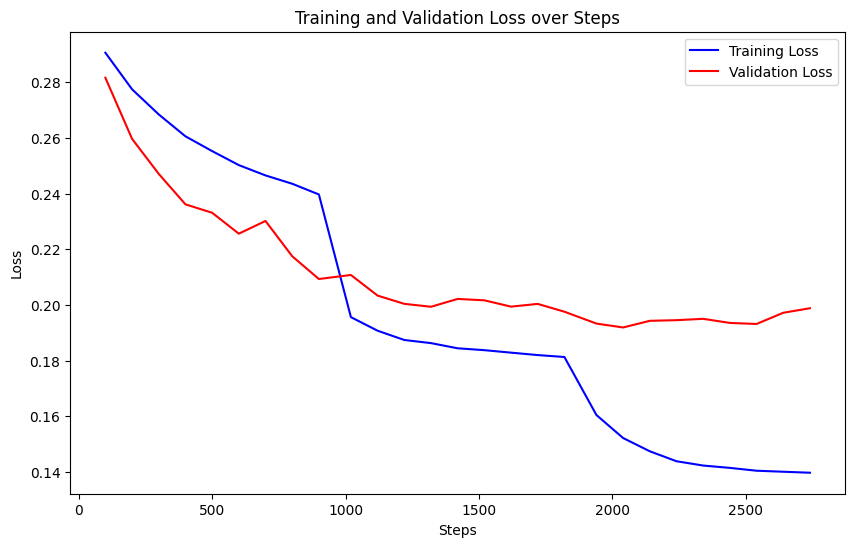

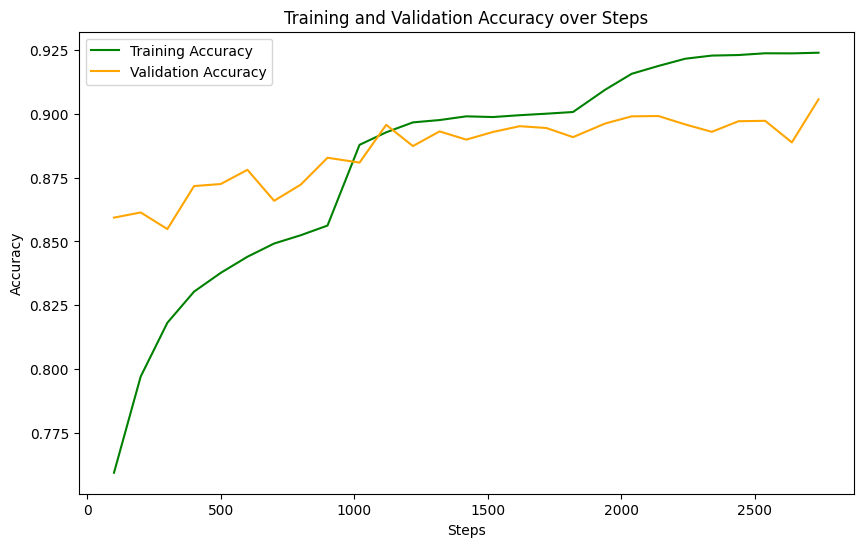

In [27]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Training Loss', color='blue')
plt.plot(steps, val_losses, label='Validation Loss', color='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Steps')
plt.legend()
plt.savefig('loss_over_steps.png')  # Save for GitHub
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(steps, train_accuracies, label='Training Accuracy', color='green')
plt.plot(steps, val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Steps')
plt.legend()
plt.savefig('accuracy_over_steps.png')  # Save for GitHub
plt.show()


In [ ]:
logits

tensor([[-1.7198, -1.0528, -5.7217, -2.9936, -6.9315, -6.8369, -3.6644, -5.3932,
         -6.3702, -6.5042, -6.4546, -4.7120, -6.1319, -4.4786, -1.5347, -3.9281,
          2.1993, -6.2719, -7.1359,  0.1573, -7.8991,  0.9520, -4.2430, -3.8469,
          0.5040, -4.6859, -7.2827,  4.2531, -8.1245],
        [-5.9300,  1.4284, -4.6893, -2.2487, -4.7979, -5.2061, -5.4636, -8.0621,
         -3.7712,  4.2674, -4.4231, -4.9068, -3.0887, -4.4090,  3.6918, -8.2256,
         -5.3227, -7.3082, -4.5319, -4.9387, -6.4784, -2.5897, -7.3554, -5.5774,
         -6.1270,  3.1624, -6.3675, -2.8810, -6.5971]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
targets

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')

In [ ]:
probs = torch.sigmoid(logits)
print(probs)

tensor([[1.5189e-01, 2.5869e-01, 3.2635e-03, 4.7715e-02, 9.7562e-04, 1.0722e-03,
         2.4980e-02, 4.5268e-03, 1.7089e-03, 1.4949e-03, 1.5708e-03, 8.9071e-03,
         2.1678e-03, 1.1222e-02, 1.7731e-01, 1.9301e-02, 9.0019e-01, 1.8850e-03,
         7.9537e-04, 5.3925e-01, 3.7096e-04, 7.2151e-01, 1.4160e-02, 2.0899e-02,
         6.2340e-01, 9.1400e-03, 6.8683e-04, 9.8598e-01, 2.9611e-04],
        [2.6514e-03, 8.0665e-01, 9.1093e-03, 9.5466e-02, 8.1793e-03, 5.4529e-03,
         4.2205e-03, 3.1516e-04, 2.2507e-02, 9.8618e-01, 1.1855e-02, 7.3420e-03,
         4.3578e-02, 1.2021e-02, 9.7568e-01, 2.6763e-04, 4.8560e-03, 6.6957e-04,
         1.0645e-02, 7.1133e-03, 1.5339e-03, 6.9806e-02, 6.3873e-04, 3.7680e-03,
         2.1784e-03, 9.5940e-01, 1.7135e-03, 5.3100e-02, 1.3624e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# PR Curve computation
pr_curves = {}
for tone_idx in range(len(tone_to_num)):
    y_true = np.array(all_targets)[:, tone_idx]
    y_probs = np.array(all_probs)[:, tone_idx]

    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    auc_pr = auc(recall, precision)

    pr_curves[tone_idx] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds,
        'auc': auc_pr
    }


In [ ]:
# Threshold tuning with NaN handling
best_thresholds = {}
for tone_idx, pr_data in pr_curves.items():
    precision, recall, thresholds = pr_data['precision'], pr_data['recall'], pr_data['thresholds']

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores = np.nan_to_num(f1_scores, nan=0.0)  # Replace NaN with 0 for F1-scores

    best_idx = f1_scores.argmax()  # Find the index of the best F1-score
    best_thresholds[tone_idx] = thresholds[best_idx]

print("Best thresholds per tone:", best_thresholds)


Best thresholds per tone: {0: 0.11162916, 1: 0.6514165, 2: 0.21630712, 3: 0.14389549, 4: 0.32350647, 5: 0.115979, 6: 0.16642417, 7: 0.009894602, 8: 0.3565231, 9: 0.4015457, 10: 0.126615, 11: 0.1647644, 12: 0.2930054, 13: 0.13224648, 14: 0.39625317, 15: 0.24033476, 16: 0.48915368, 17: 0.01708274, 18: 0.26838228, 19: 0.15100946, 20: 0.06316491, 21: 0.2027411, 22: 0.22020632, 23: 0.34273216, 24: 0.31572622, 25: 0.4312237, 26: 0.10447431, 27: 0.24771017, 28: 0.12821943}


In [ ]:
# Loop through each tone to check precision and recall at the best threshold
for tone_idx, pr_data in pr_curves.items():
    best_threshold = best_thresholds[tone_idx]
    thresholds = pr_data['thresholds']

    # Find the index of the best threshold
    best_idx = (thresholds == best_threshold).nonzero()[0][0]

    # Get precision and recall at the best threshold
    best_precision = pr_data['precision'][best_idx]
    best_recall = pr_data['recall'][best_idx]

    print(f"Tone {tone_idx}:")
    print(f"  Best Threshold: {best_threshold}")
    print(f"  Precision at Best Threshold: {best_precision}")
    print(f"  Recall at Best Threshold: {best_recall}")
    print()

Tone 0:
  Best Threshold: 0.11162915825843811
  Precision at Best Threshold: 0.5918367346938775
  Recall at Best Threshold: 0.48333333333333334

Tone 1:
  Best Threshold: 0.6514164805412292
  Precision at Best Threshold: 0.8252947481243301
  Recall at Best Threshold: 0.876993166287016

Tone 2:
  Best Threshold: 0.2163071185350418
  Precision at Best Threshold: 0.2978723404255319
  Recall at Best Threshold: 0.2916666666666667

Tone 3:
  Best Threshold: 0.1438954919576645
  Precision at Best Threshold: 0.3112128146453089
  Recall at Best Threshold: 0.7272727272727273

Tone 4:
  Best Threshold: 0.3235064744949341
  Precision at Best Threshold: 0.6086956521739131
  Recall at Best Threshold: 0.6363636363636364

Tone 5:
  Best Threshold: 0.11597900092601776
  Precision at Best Threshold: 0.288135593220339
  Recall at Best Threshold: 0.4722222222222222

Tone 6:
  Best Threshold: 0.16642417013645172
  Precision at Best Threshold: 0.3333333333333333
  Recall at Best Threshold: 0.523809523809523

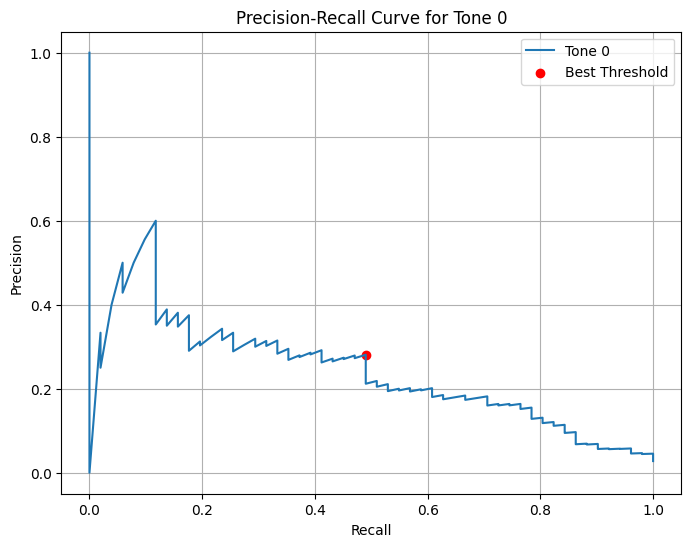

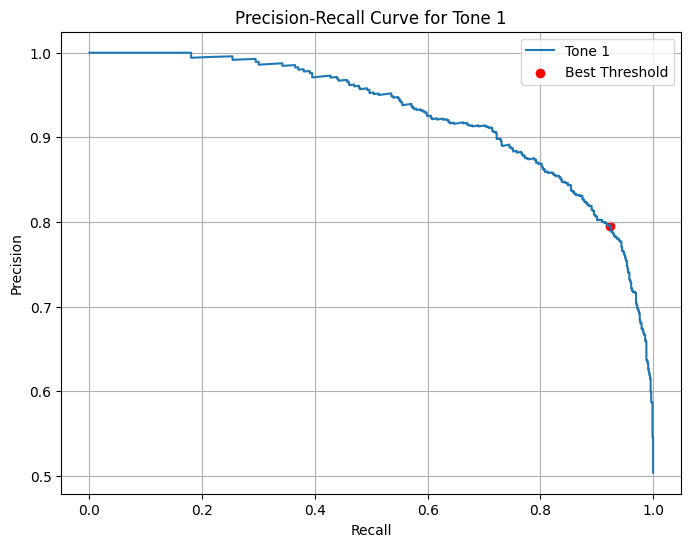

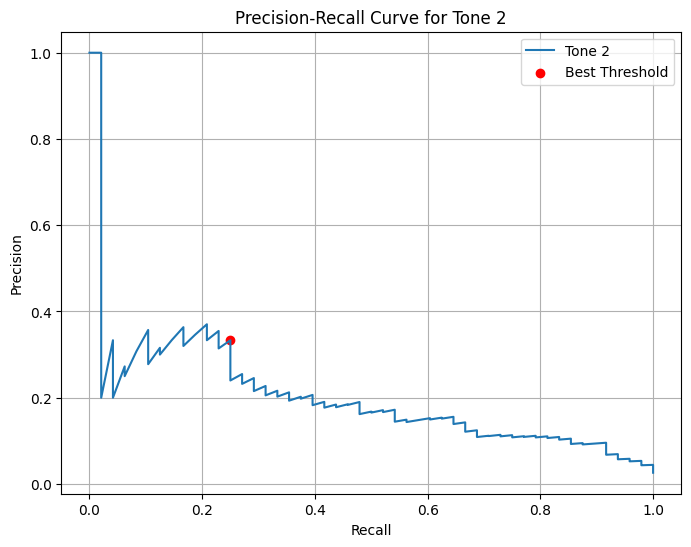

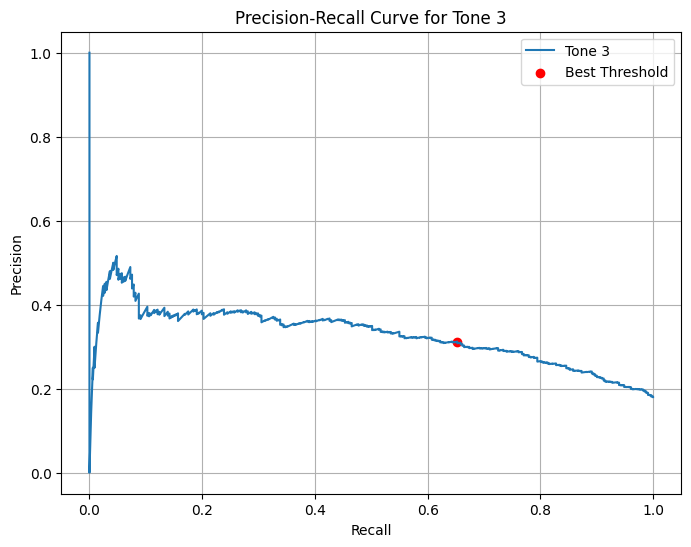

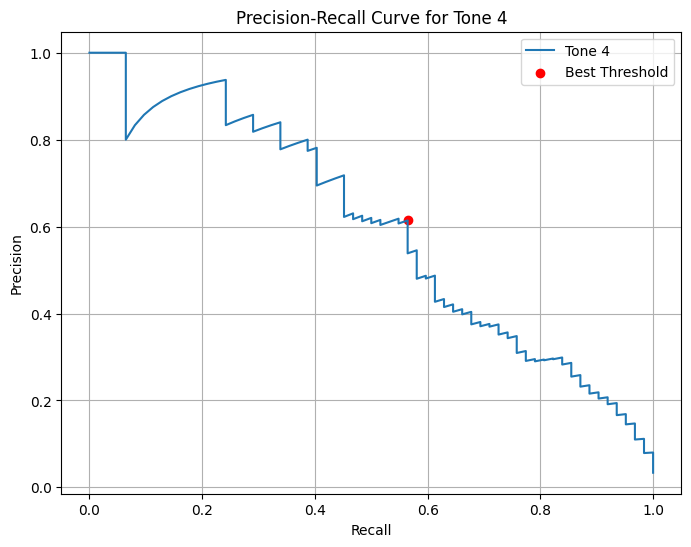

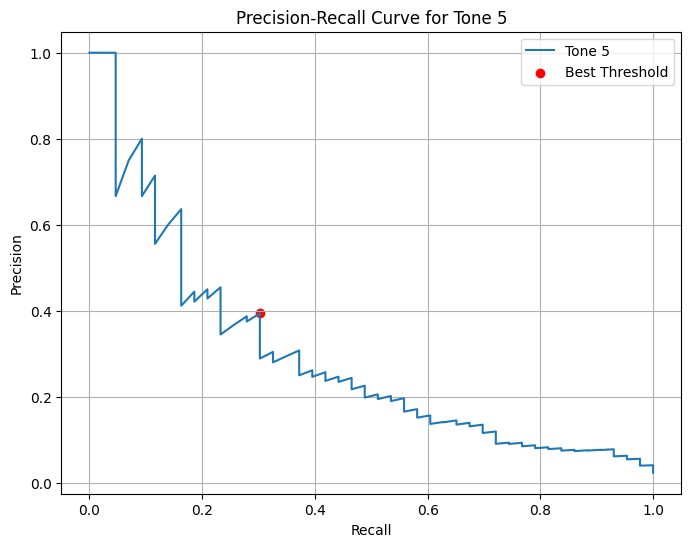

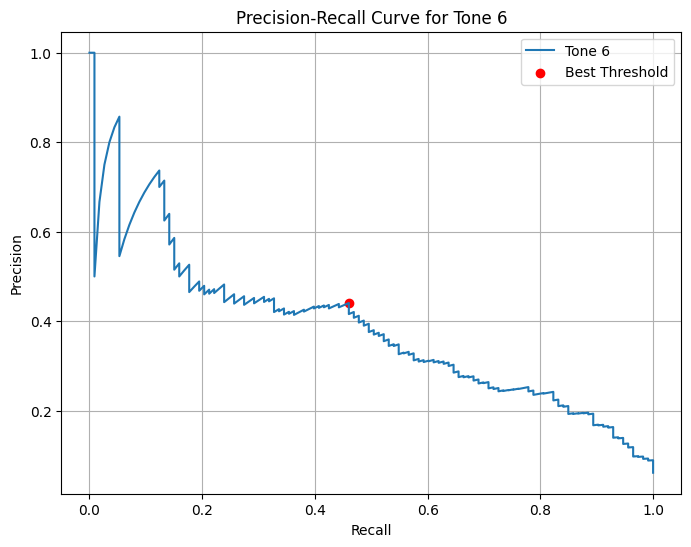

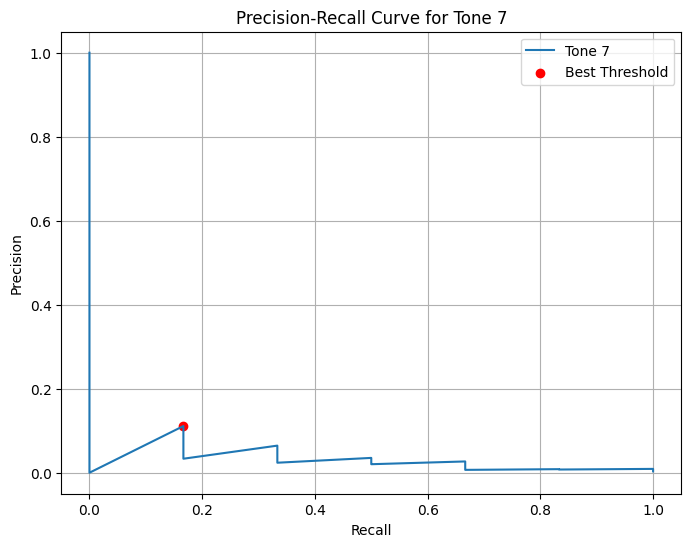

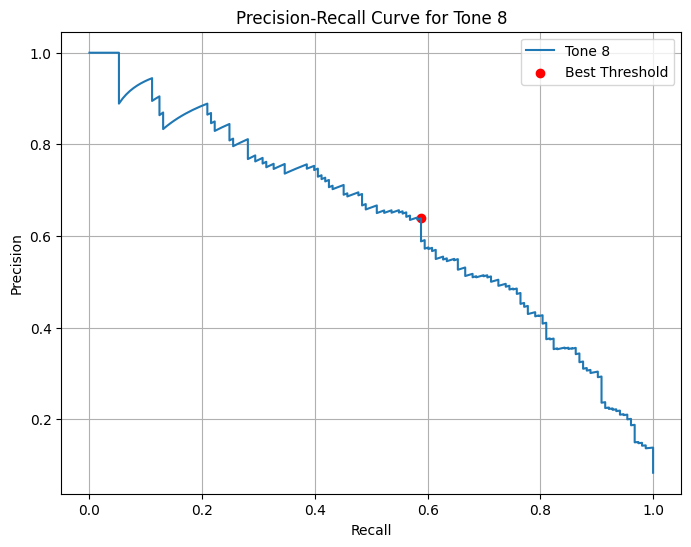

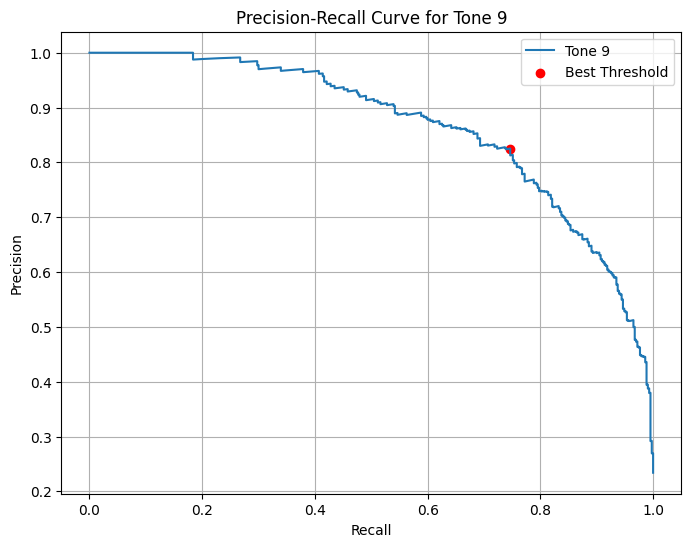

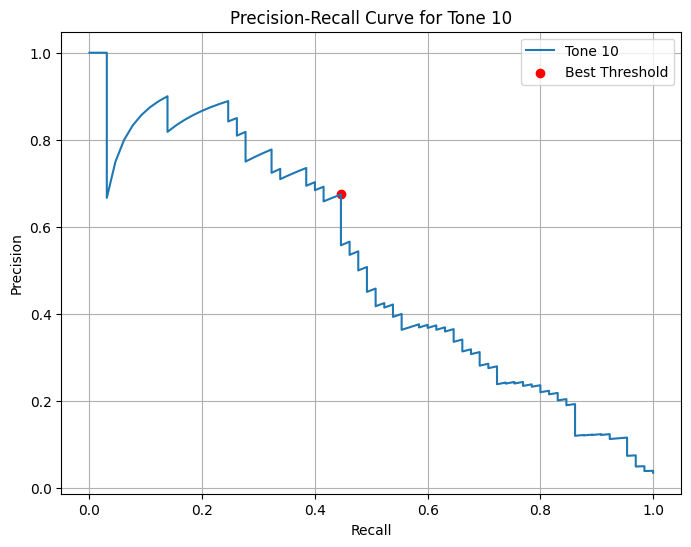

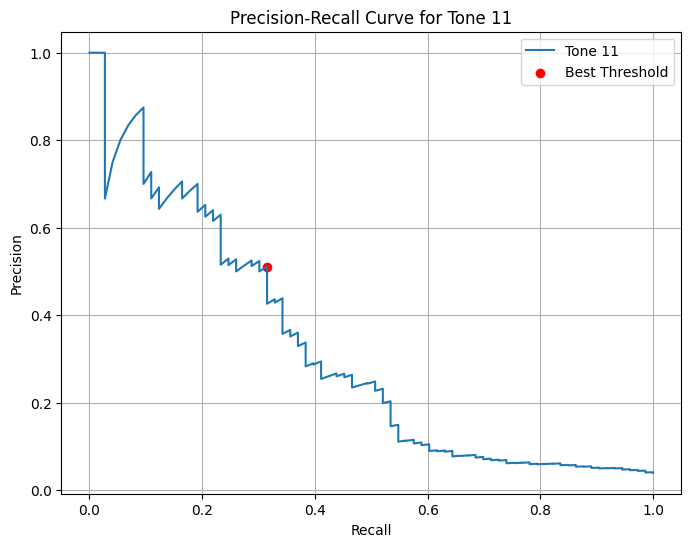

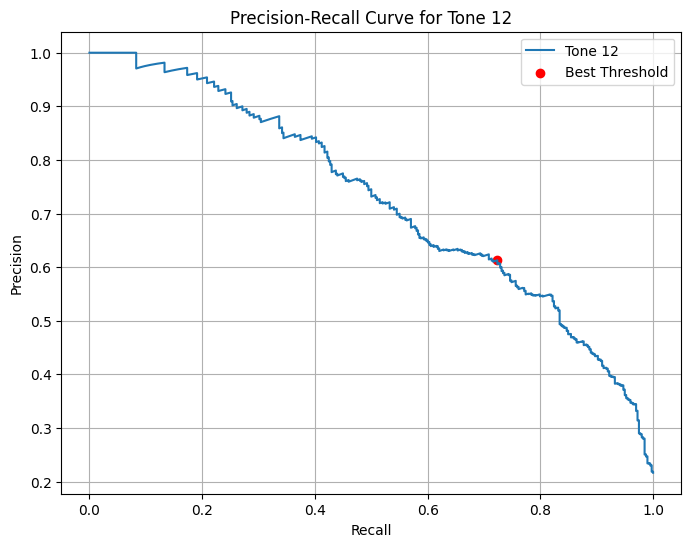

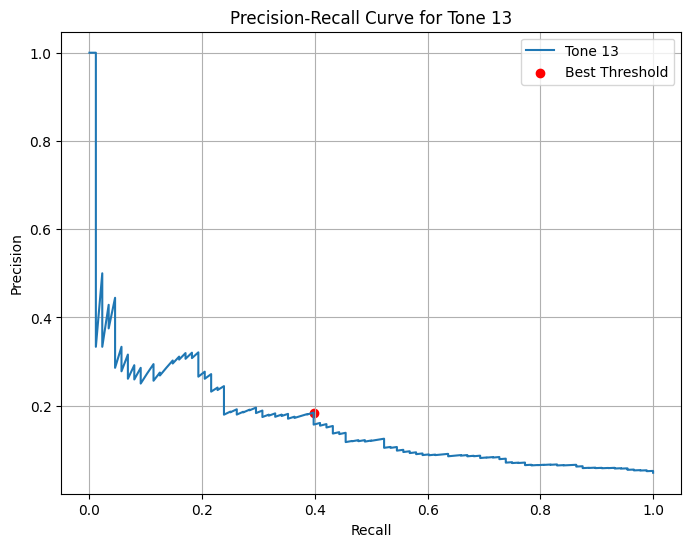

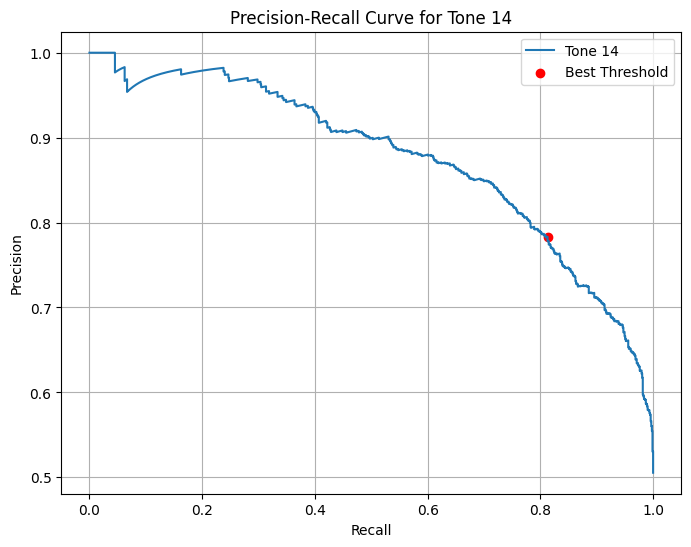

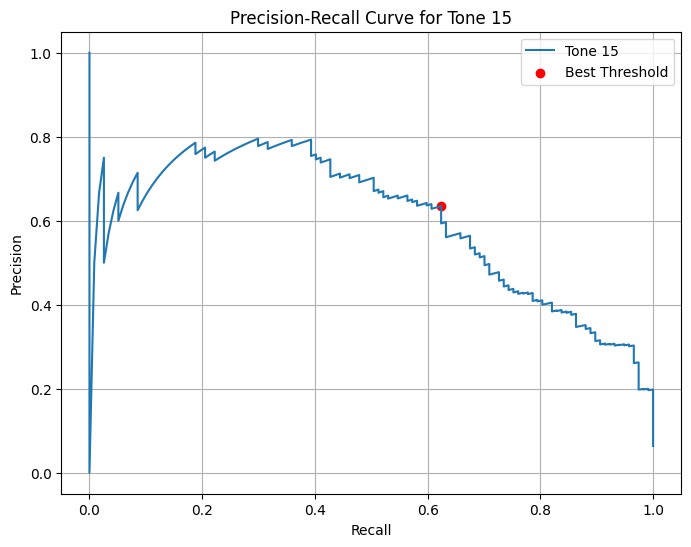

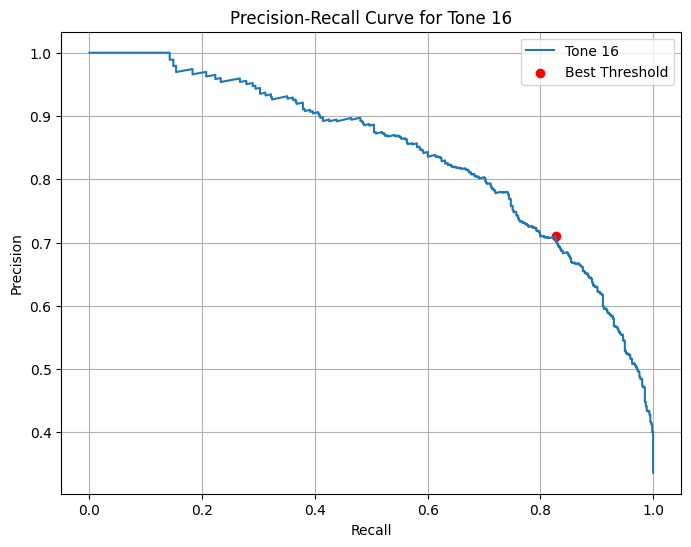

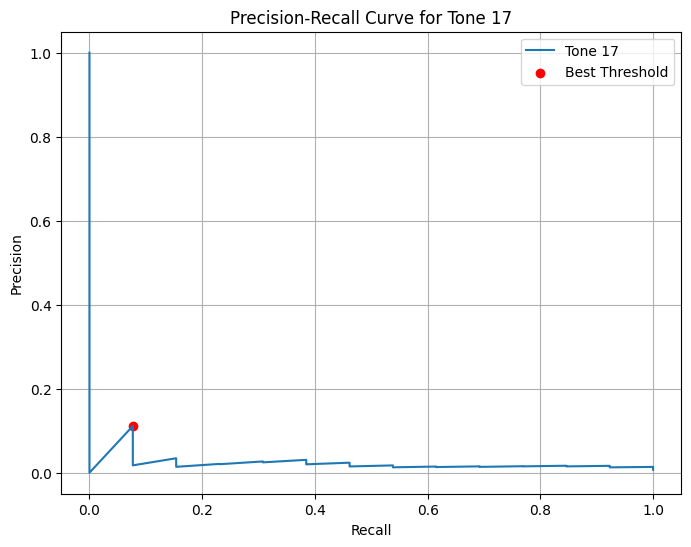

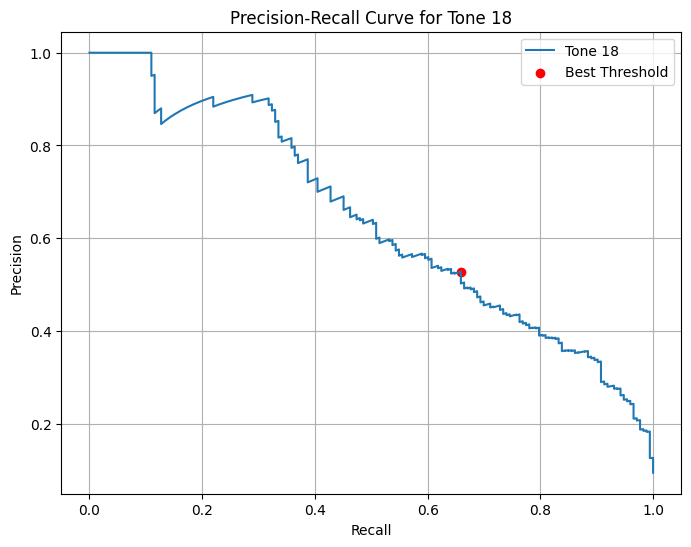

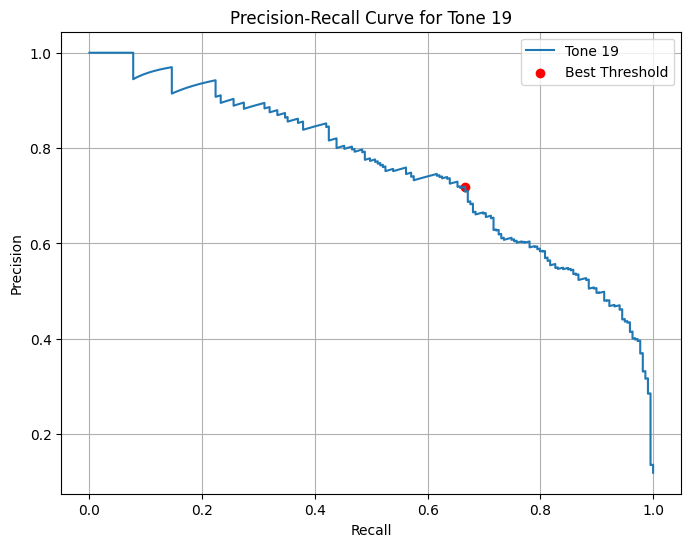

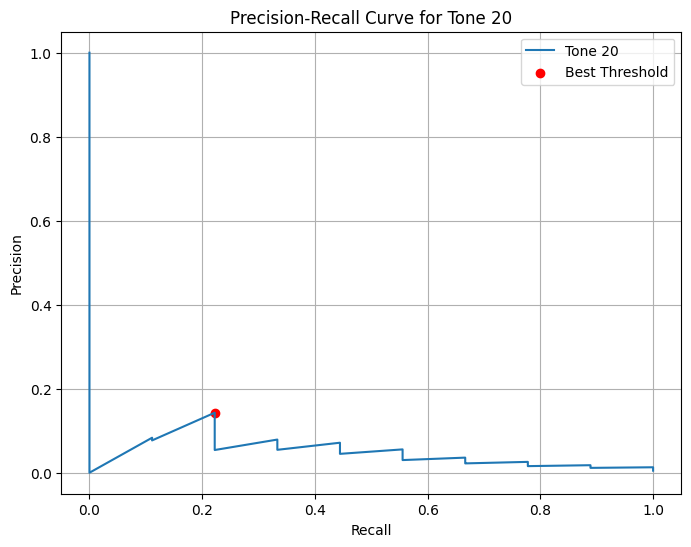

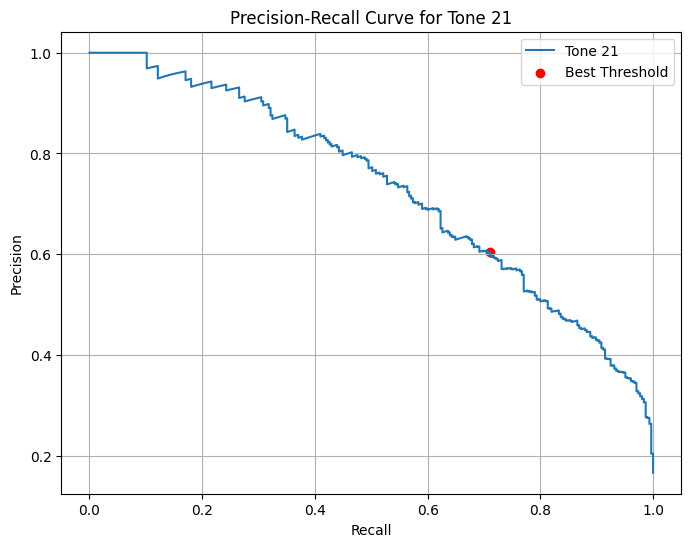

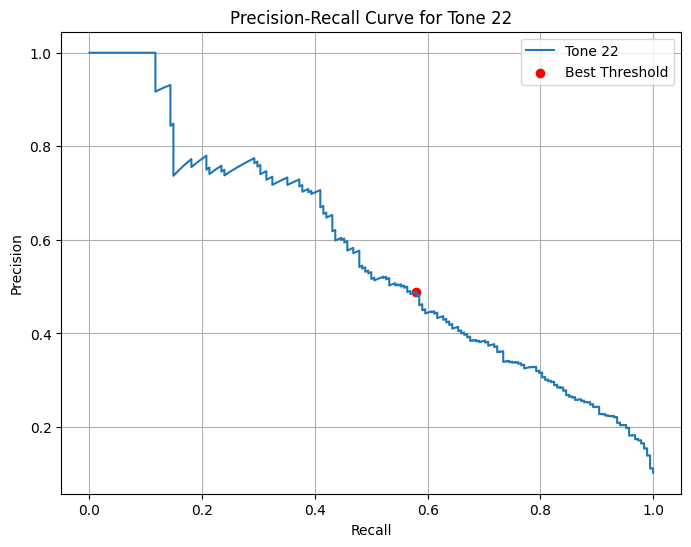

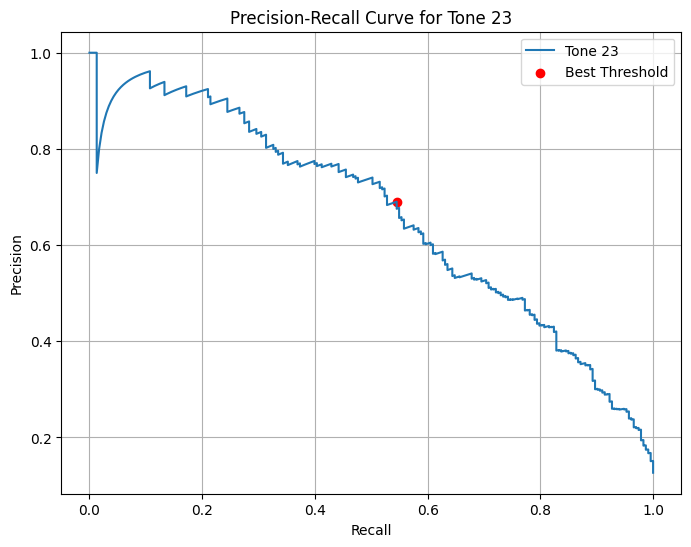

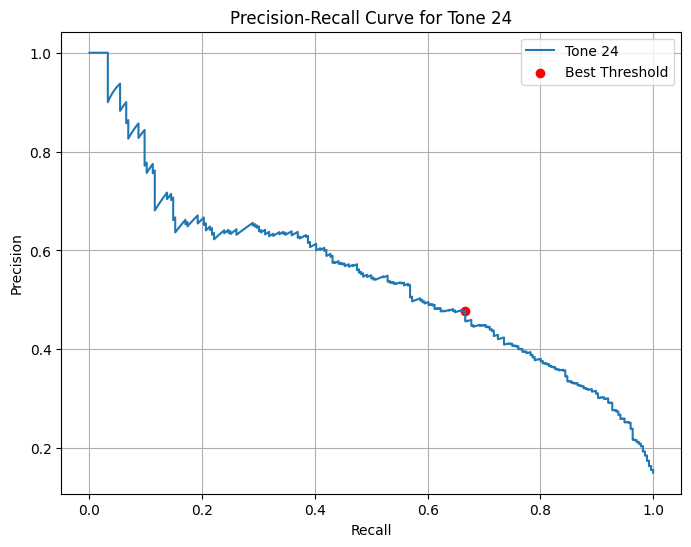

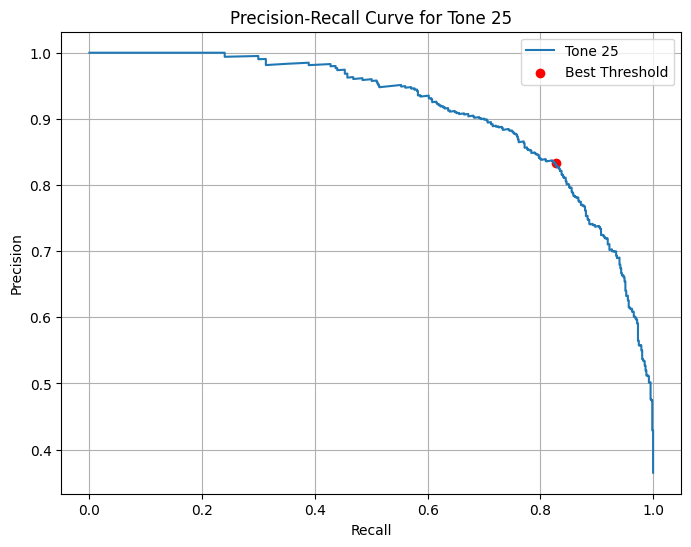

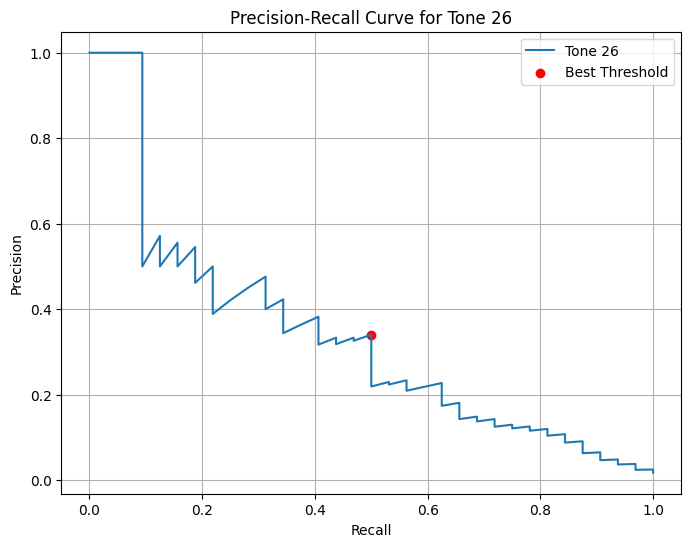

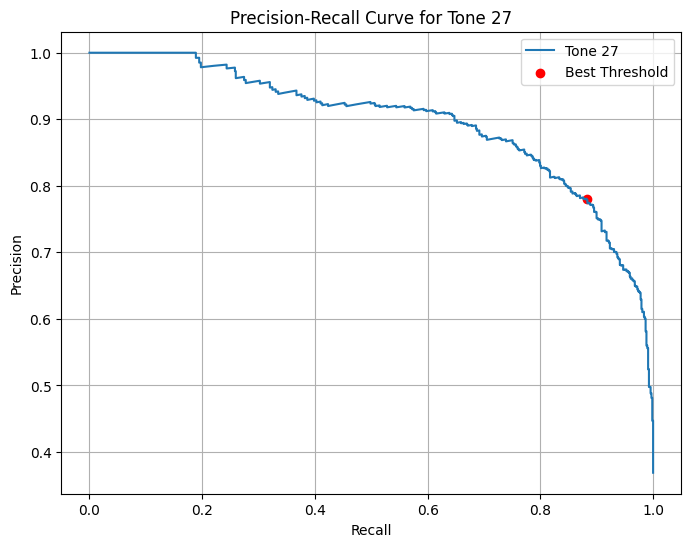

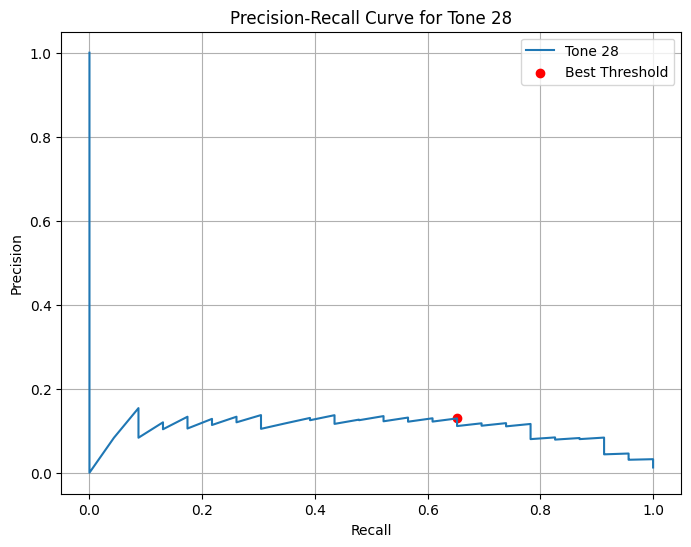

In [ ]:
# Plot PR curves with best thresholds
for tone_idx, pr_data in pr_curves.items():
    best_threshold = best_thresholds[tone_idx]
    precision, recall, thresholds = pr_data['precision'], pr_data['recall'], pr_data['thresholds']

    # Find the index of the best threshold
    best_idx = (thresholds == best_threshold).nonzero()[0][0]

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Tone {tone_idx}')
    plt.scatter(recall[best_idx], precision[best_idx], color='red', label='Best Threshold')
    plt.title(f'Precision-Recall Curve for Tone {tone_idx}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()


<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

This unseen data is the 20% of `generated_emotional_tones.tsv` which was seperated during the Dataset creation stage.
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model.

As you can see the model is predicting the correct category of a given sample to a 90.23% accuracy.

In [28]:
valid_acc, valid_loss, all_preds, all_probs, all_targets, tone_predictions = valid(model, testing_loader, best_thresholds)
print("Accuracy on test data = %0.2f%%" % (valid_acc * 100))


Overall Metrics:
Validation Loss: 0.1999
Validation Accuracy: 0.9023
Precision: 0.6413
Recall: 0.7408
F1 Score: 0.6762
Accuracy on test data = 90.23%


<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model.

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

In [29]:
output_model_file = 'pytorch_roberta_emotional_tone_prediction_in_movies.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed
